In [1]:
## Digit recognizer 
# In this Jupyter Notebook, we build a series of machine learning methods to recognize digits 
# from images. The data has been take from the Kaggle competition.

# Import  default modules
import os
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod

# Import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import ML modules
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, SCORERS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, \
    cross_val_score, RepeatedKFold, KFold, StratifiedKFold, GridSearchCV
from lightgbm import LGBMClassifier

Using TensorFlow backend.


In [2]:
# Configuration - Initial Parameters used for optimization of the ML algorithms
BATCH_SIZE = 64
EPOCHS = 20
K = 2
RND = 13

In [3]:
# Define here the preprocessing steps
def pipeline_tf(df, train):
    if train:
        return df.iloc[:, 1:].values.astype('float32').reshape(-1, 28, 28, 1) / 255.0, df.iloc[:, :1].values
    else:
        return df.iloc[:, :].values.astype('float32').reshape(-1, 28, 28, 1) / 255.0, None
    
def pipeline_sk(df, train):
    scaler = StandardScaler()   
    if train:
        return scaler.fit_transform(df.iloc[:, 1:]), df.iloc[:, :1]
    else:
        return scaler.fit_transform(df.iloc[:, 1:]), None

# Define Abstract class   
class DataReader(ABC):  
    def __init__(self, path, pipeline=None, file=None, train=True):
        self._path = path
        self._path_file = os.path.join(self._path, file)
        self._data = None
        self._pipeline = pipeline
        self._train = train
        self.x = None
        self.y = None        
        
    def _read(self):
        self._data = pd.read_csv(self._path_file)
    
    def _format(self):
        if self._pipeline is not None:
            return self._pipeline(self._data, self._train)
        else:
            return self._data, None
    
    @abstractmethod
    def get(self):
        return None
        
# Define specific class for scikit-learn
class ReaderSK(DataReader):
    def __init__(self, path, pipeline, file='train.csv', train=True):
         super().__init__(path=path, pipeline=pipeline, file=file, train=train)
        
    def get(self):
        self._read()
        self.x, self.y = self._format()  
        return self.x, self.y
 
# Define specific class for tensorflow/keras 
class ReaderTF(DataReader):
    def __init__(self, path, pipeline,  file='train.csv', train=True):
        super().__init__(path=path, pipeline=pipeline, file=file, train=train)
        
    def get(self):
        self._read()
        self.x, self.y = self._format()  
        return self.x, self.y

class ModelItinerator(ABC):    
    @abstractmethod
    def train(self):
            return None
               
    @abstractmethod
    def _predict(self, x):
            return None\
    
    @abstractmethod
    def evaluate(self):
            return None
        
    @abstractmethod
    def infer(self):
            return None

class ModelSK(ModelItinerator):    
    def __init__(self, models, params=None, scoring=None, reader=ReaderSK, pipeline=pipeline_sk):
        self._models = models
        self._params = params
        self._scoring = scoring
        self._scores = []
        self._preds = []
        self._reader_train = reader(path='./data/', pipeline=pipeline)
        self._reader_test = reader(path='./data/', pipeline=pipeline, file='test.csv', train=False)
        self._x_train = None
        self._y_train = None
        self._x_test = None
        super().__init__()
    
    def train(self):        
        # Extract data
        self._scores = []
        self._x_train, self._y_train  = self._reader_train.get()
        
        # Run cross-validation
        cv = KFold(n_splits=K, random_state=RND)        
        for i, model in enumerate(self._models):
            if self._params is not None:
                clf = GridSearchCV(model, param_grid=self._params, cv=cv)
                clf.fit(self._x_train, self._y_train)
                self._models[i] = clf.best_estimator_
                print(clf.best_params_)            
                self._scores.append(clf.best_score_)
            elif self._scoring is None:
                scores = cross_val_score(model, self._x_train, self._y_train, cv=cv)
                print(scores)
                print(type(scores))
                self._scores.append(np.mean(scores))
            else:
                scores = cross_validate(model, self._x_train, self._y_train, cv=cv, scoring=scoring)      
                print(scores)
                print(type(scores))
                self._scores.append(scores)  

    def _predict(self, x):
        self._preds = []
        for i, model in enumerate(self._models):
            self._preds.append(model.predict(x))
        return self._preds
            
    def evaluate(self):
        return self._predict(self._x_train)
    
    def infer(self):
        self._x_test, _  = self._reader_train.get()
        return self._predict(self._x_train)

In [ ]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr_weighted']        
parameters = [{'C':[1, 10, 50. / 5000]}]
models = [RandomForestClassifier(n_estimators = 500, random_state=RND)]

# models = [LogisticRegression(C= penalty='l1', solver='saga', tol=0.1, random_state=RND),
#               RandomForestClassifier(n_estimators = 500, random_state=RND),
#               LGBMClassifier(random_state=RND)]

#SVC(probability=True)
model = ModelSK(models=models)   
model.train()
print(model._scores)

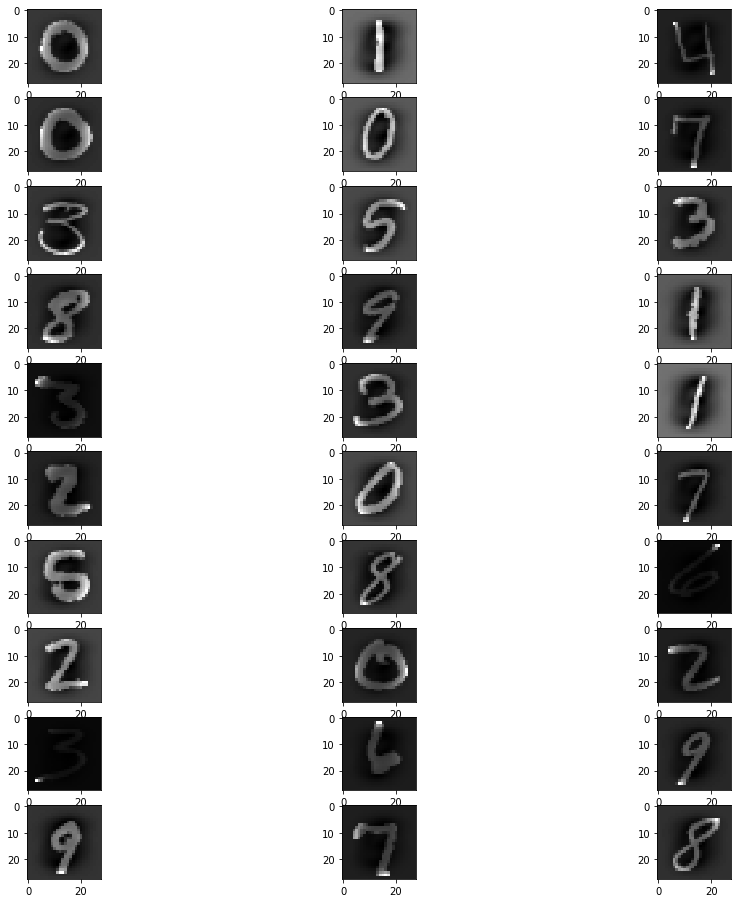

In [29]:
# Visualization 
rows = 10
cols = 3
fig = plt.figure(figsize=(16, 16))
for i in range(1, cols * rows + 1):        
    img, _ = ReaderSK(path='./data/', pipeline=pipeline_sk).get()
    img = img[i, :].reshape((28,28))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [4]:
#  Deep learning - Architecture
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer = 'he_normal', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3) , activation='relu', padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Flatten(),                        
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience = 3,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.0001)
datagen = ImageDataGenerator(featurewise_center=False, # set input mean to 0 over the dataset
                            samplewise_center = False, # set each sample mean to 0
                            featurewise_std_normalization = False, # divide inputs by std of the dataset
                            samplewise_std_normalization = False, # divide each input by its std
                            zca_whitening = False, # apply ZCA whitening
                            rotation_range = 15, # randomly rotate images in the range (degrees, 0 to 180)
                            zoom_range = 0.1, # Randomly zoom image 
                            width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
                            height_shift_range = 0.1, # randomly shift images vertically (fraction of total height)
                            horizontal_flip = False, # randomly flip images
                            vertical_flip = False) # randomly flip images - we do not want this as it e.g. messes up the digits 6 and 9

In [ ]:
# Training - Deep learning 
model = KerasClassifier(build_fn=get_compiled_model, 
                                 epochs=50, 
                                 batch_size=64, 
                                 verbose=1)
models = [model]
model = ModelSK(models=models, reader=ReaderTF, pipeline=pipeline_tf)  
model.train()

C:\Projects\venv\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train on 21000 samples
Epoch 1/50
 1664/21000 [=>............................] - ETA: 1:45 - loss: 1.4661 - accuracy: 0.5337

In [5]:
# Training - Deep learning (Manual)
reader_train = ReaderTF(path='./data/', pipeline=pipeline_tf)
reader_test = ReaderTF(path='./data/', pipeline=pipeline_tf, file='test.csv', train=False)
x_train, y_train = reader_train.get()
x_test, y_test = reader_test.get()
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = dataset.shuffle(x_train.shape[0]).batch(64)
model = get_compiled_model()
model.summary()
datagen.fit(x_train)
model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch = x_train.shape[0] // BATCH_SIZE, 
                    epochs=EPOCHS, callbacks = [learning_rate_reduction], verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

C:\Projects\venv\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Projects\venv\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Projects\venv\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Projects\venv\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,lr
  

In [6]:
# Inference - Deep learning (Manual)
# Evaluate the model on training set
score = model.evaluate(x_train, y_train, verbose=0)
print(score)

# Generage predictions on the test set
predicted_labels = model.predict_classes(x_test).astype(int)

def generator(preds):
    df = pd.DataFrame(data=preds)
    df.columns = ['Label']
    df.index += 1
    df.index.name = 'ImageId'
    df.to_csv('predicted_labels.csv', index=True)    
generator(predicted_labels)

[0.010528064276684226, 0.99695235]
